Quick analysis

In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

from pygama import DataGroup
import pygama.io.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf

In [2]:
dg = DataGroup('cage.json', load=True)
run = 70
str_query = f'run=={run} and skip==False'
dg.file_keys.query(str_query, inplace=True)
view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(dg.file_keys[view_cols])

Loading file key list from: ./fileDB.h5
    runtype  run  cycle     startTime    runtime  threshold
867     alp   64    869  1.602171e+09  29.984760       16.0
868     alp   64    870  1.602172e+09  29.996250       16.0
869     alp   64    871  1.602174e+09  29.986685       16.0
870     alp   64    872  1.602176e+09  29.993093       16.0
871     alp   64    873  1.602178e+09  29.998897       16.0
872     alp   64    874  1.602180e+09  29.971984       16.0
873     alp   64    875  1.602181e+09  29.995355       16.0
874     alp   64    876  1.602183e+09  29.998476       16.0
875     alp   64    877  1.602185e+09  29.976009       16.0
876     alp   64    878  1.602187e+09  29.997642       16.0


In [3]:
#get runtime, startime, runtype

runtype_list = np.array(dg.file_keys['runtype'])
runtype = runtype_list[0]

rt_min = dg.file_keys['runtime'].sum()
u_start = dg.file_keys.iloc[0]['startTime']
t_start = pd.to_datetime(u_start, unit='s') # str

In [4]:
# get scan position

if runtype == 'alp':
    alphaDB = pd.read_hdf('alphaDB.h5')
    scan_pos = alphaDB.loc[alphaDB['run']==run]
    radius = np.array(scan_pos['radius'])[0]
    angle = np.array(scan_pos['angle'])[0]
    angle_det = 270 + angle
    print(f'Radius: {radius}; Angle: {angle}')
    
else:
    radius = 'n/a'
    angle = 'n/a'
    angle_det = 'n/a'

Radius: 7.5; Angle: -180.0


In [5]:
lh5_dir = dg.lh5_user_dir #if user else dg.lh5_dir
print(lh5_dir)
hit_list = lh5_dir + dg.file_keys['hit_path'] + '/' + dg.file_keys['hit_file']
print(hit_list)
df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max'], 'ORSIS3302DecoderForEnergy/hit')
# df_hit = lh5.load_dfs(alpha_hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw'], 'ORSIS3302DecoderForEnergy/hit')
# print(df_hit)
# print(df_hit.columns)

# dsc = df_hit[['bl','bl_sig','A_10','AoE', 'ts_sec', 'dcr_raw', 'dcr_ftp', 'dcr_max']].describe()
# dsc = df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr_raw']].describe()
# print(dsc)

/global/homes/g/gothman/projecta/CAGE_lh5_joule/
867    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
868    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
869    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
870    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
871    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
872    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
873    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
874    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
875    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
876    /global/homes/g/gothman/projecta/CAGE_lh5_joul...
dtype: object


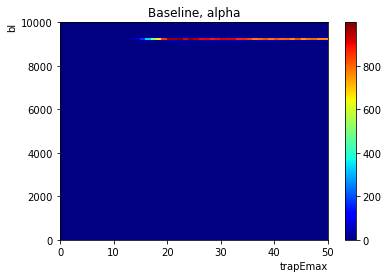

In [6]:
# Baseline vs E

etype = 'trapEmax'

elo, ehi, epb = 0, 50, 1
blo, bhi, bpb = 0, 10000, 100
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(df_hit['trapEmax'], df_hit['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], cmap='jet')

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
plt.title('Baseline, alpha')
# plt.tight_layout()
plt.show()

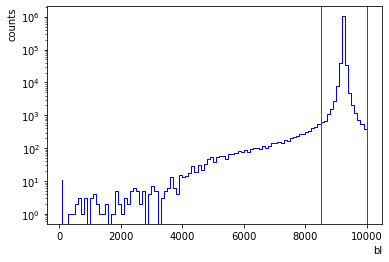

In [7]:
blo, bhi, bpb = 0, 10000, 100
nbx = int((bhi-blo)/bpb)

bl_hist, bins = np.histogram(df_hit['bl'], bins=nbx,
                range=[blo, bhi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

bl_cut_lo, bl_cut_hi = 8500,10000

plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

In [8]:
# use baseline cut
df_cut = df_hit.query('bl > 8500 and bl < 10000').copy()

#create dcr/E 
df_cut['dcr_norm'] = df_cut['dcr_raw'] / df_cut['trapEmax']

#creat new DCR
const = 0.0555
df_cut['dcr_linoff'] = df_cut['dcr_raw'] + const*df_cut['trapEmax']

# #create 10-90
# df_cut['10-90'] = df_cut['tp_90']- df_cut['tp_10']

# #create 50-90
# df_cut['50-90'] = df_cut['tp_90']- df_cut['tp_50']

#create 0-50
df_cut['tp0_50'] = df_cut['tp_50']- df_cut['tp_0']

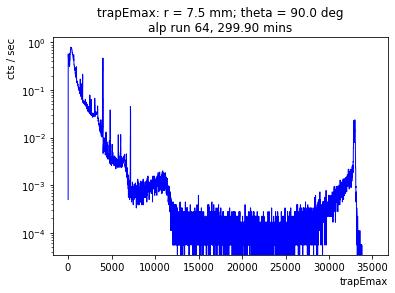

In [9]:
# Make energy spectrum
elo, ehi, epb = 0, 35000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, bins = np.histogram(df_cut['trapEmax'], bins=nbx,
                range=[elo, ehi])
energy_rt = np.divide(energy_hist, rt_min * 60)

plt.semilogy(bins[1:], energy_rt, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
# plt.legend()
plt.title(f'{etype}: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
plt.show()

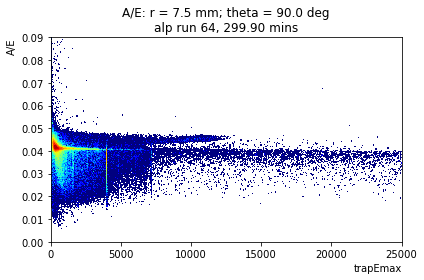

In [10]:
# Alpha A/E
alo, ahi, apb = 0.0, 0.09, 0.0001
elo, ehi, epb = 0, 25000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(df_cut['trapEmax'], df_cut['AoE'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
# plt.legend()
plt.title(f'A/E: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_a10oE_run{run}.png', dpi=200)
plt.show()

In [11]:
# # DCR vs E
# etype = 'trapEmax'
# #       elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 25000, 10
# # dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

# nbx = int((ehi-elo)/epb)
# nby = int((dhi-dlo)/dpb)

# alpha_dcr_hist = plt.hist2d(df_cut['trapEmax'], df_cut['dcr_norm'], bins=[nbx,nby],
#                 range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

# plt.xlabel('trapEmax', ha='right', x=1)
# plt.ylabel('DCR_norm', ha='right', y=1)
# plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
# plt.tight_layout()
# # plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
# plt.show()

In [12]:
# old_dcr_cut = df_cut.query('trapEmax > 5000 and trapEmax < 15000 and dcr_norm > -0.0515 and dcr_norm < -0.02').copy()
# len(old_dcr_cut)

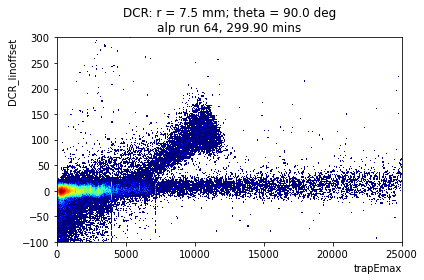

In [13]:
# DCR new vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

dlo, dhi, dpb = -100, 300, 0.6

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut['trapEmax'], df_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


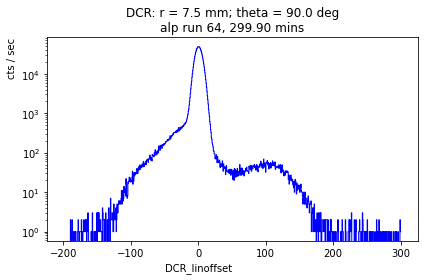

In [14]:
# DCR 1D hist
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 15000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

# dlo, dhi, dpb = 0, 200, 1
dlo, dhi, dpb = -200, 300, 0.6

nbx = int((dhi-dlo)/dpb)

dcr_hist, bins = np.histogram(df_cut['dcr_linoff'], bins=nbx,
                range=[dlo, dhi])

plt.semilogy(bins[1:], dcr_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('DCR_linoffset', ha='right', y=1)
plt.ylabel('cts / sec', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_1d_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

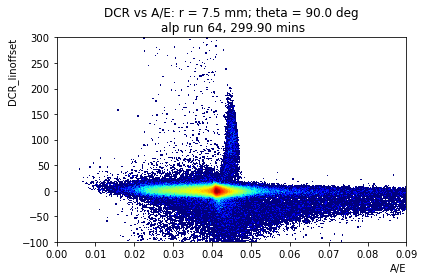

In [15]:
# DCR vs A/E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

alo, ahi, apb = 0.0, 0.09, 0.0001
dlo, dhi, dpb = -100, 300, 0.6
# dlo, dhi, dpb = 15, 300, 0.6

nbx = int((ahi-alo)/apb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(df_cut['AoE'], df_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[alo, ahi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('A/E', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR vs A/E: r = {radius} mm; theta = {angle_det} deg\n {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_a10oE_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

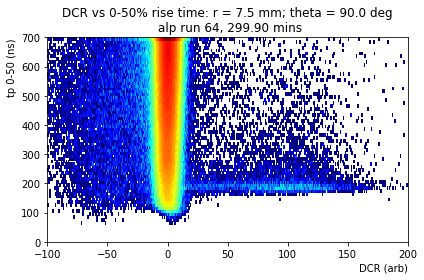

In [16]:
# DCR vs 0-50


dlo, dhi, dpb = -100, 200, 0.6
tlo, thi, tpb = -0, 700, 10

nbx = int((dhi-dlo)/dpb)
nby = int((thi-tlo)/tpb)

alpha_dcr_hist = plt.hist2d(df_cut['dcr_linoff'], df_cut['tp0_50'], bins=[nbx,nby],
                range=[[dlo, dhi], [tlo, thi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('DCR (arb)', ha='right', x=1)
plt.ylabel('tp 0-50 (ns)', ha='right', y=1)
plt.title(f'DCR vs 0-50% rise time: r = {radius} mm; theta = {angle_det} deg\n {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_tp0_50_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [17]:
# alpha_cut = 'dcr_linoff > 25 and dcr_linoff < 200 and AoE >0.04 and AoE < 0.05 and trapEmax < 15000'
# alpha_cut = 'trapEmax < 12000 and dcr_linoff > 15 or dcr_linoff < -10'
alpha_cut = 'dcr_linoff > 25 and dcr_linoff < 200 and tp0_50 > 100 and tp0_50 < 400 and trapEmax < 12000'
new_dcr_cut = df_cut.query(alpha_cut).copy()
len(new_dcr_cut)

5973

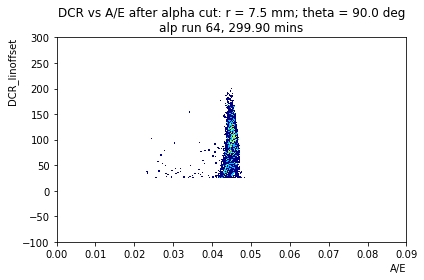

In [18]:
# DCR vs A/E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

alo, ahi, apb = 0.0, 0.09, 0.0001
dlo, dhi, dpb = -100, 300, 0.6

nbx = int((ahi-alo)/apb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(new_dcr_cut['AoE'], new_dcr_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[alo, ahi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('A/E', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR vs A/E after alpha cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_alphaCut_a10oE_vs_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

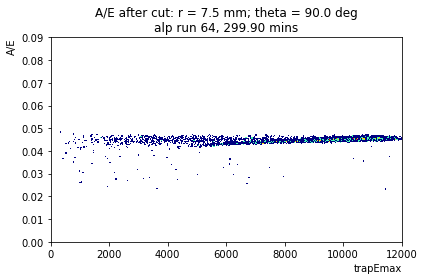

In [19]:
# Alpha A/E
alo, ahi, apb = 0.0, 0.09, 0.0001
# elo, ehi, epb = 0, 25000, 10
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 12000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(new_dcr_cut['trapEmax'], new_dcr_cut['AoE'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
# plt.legend()
plt.title(f'A/E after cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_alphaCut_a10oE_run{run}.png', dpi=200)
plt.show()

In [20]:
# # alpha_cut = 'dcr_linoff > 25 and dcr_linoff < 200 and AoE >0.04 and AoE < 0.05 and trapEmax < 15000'
# aoe_cut = 'trapEmax > 2000 and trapEmax < 12000 and AoE >0.03 and AoE < 0.045'
# aoe_df = df_cut.query(aoe_cut).copy()
# len(aoe_df)

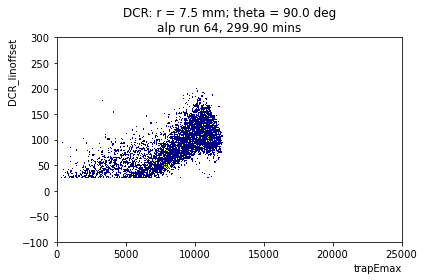

In [21]:
# DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

dlo, dhi, dpb = -100, 300, 0.6

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist = plt.hist2d(new_dcr_cut['trapEmax'], new_dcr_cut['dcr_linoff'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm()) #

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR_linoffset', ha='right', y=1)
plt.title(f'DCR: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_alphaCut_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

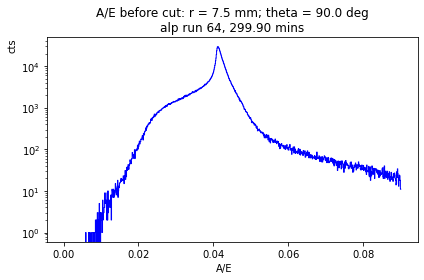

In [22]:
# 1d A/E before cut
alo, ahi, apb = 0.0, 0.09, 0.0001

nbx = int((ahi-alo)/apb)

aoe_hist, bins = np.histogram(df_cut['AoE'], bins=nbx,
                range=[alo, ahi])

plt.semilogy(bins[1:], aoe_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('A/E', ha='right', y=1)
plt.ylabel('cts', ha='right', y=1)
plt.title(f'A/E before cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_1d_aoe_run{run}.png', dpi=200)
plt.show()

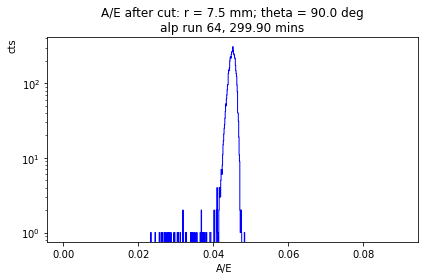

In [23]:
# 1d A/E after cut
alo, ahi, apb = 0.0, 0.09, 0.0001

nbx = int((ahi-alo)/apb)

cut_aoe_hist, bins = np.histogram(new_dcr_cut['AoE'], bins=nbx,
                range=[alo, ahi])

plt.semilogy(bins[1:], cut_aoe_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('A/E', ha='right', y=1)
plt.ylabel('cts', ha='right', y=1)
plt.title(f'A/E after cut: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
plt.savefig(f'./plots/normScan/{runtype}_alphaCut_1d_aoe_run{run}.png', dpi=200)
plt.show()

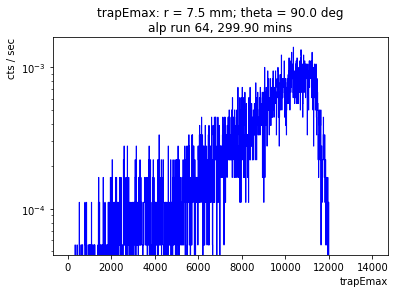

In [24]:
# Make energy spectrum
elo, ehi, epb = 0, 14000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, bins = np.histogram(new_dcr_cut['trapEmax'], bins=nbx,
                range=[elo, ehi])
energy_rt = np.divide(energy_hist, rt_min * 60)

plt.semilogy(bins[1:], energy_rt, ds='steps', c='b', lw=1) #, label=f'{etype}'

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
# plt.legend()
plt.title(f'{etype}: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.savefig(f'./plots/normScan/{runtype}_alphaCut_energy_run{run}.pdf', dpi=200)
plt.show()

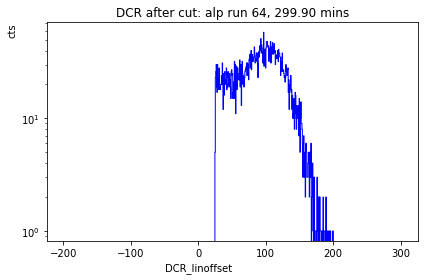

In [25]:
# DCR 1D hist after cut
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 15000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -0.1, 0.025, 0.0005

# dlo, dhi, dpb = -20, 20, 1
dlo, dhi, dpb = -200, 300, 0.6

nbx = int((dhi-dlo)/dpb)

dcr_hist, dcrbins = np.histogram(new_dcr_cut['dcr_linoff'], bins=nbx,
                range=[dlo, dhi])

plt.semilogy(dcrbins[1:], dcr_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'



# plt.legend()
plt.xlabel('DCR_linoffset', ha='right', y=1)
plt.ylabel('cts', ha='right', y=1)
plt.title(f'DCR after cut: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_1d_dcr_linoffset_run{run}.png', dpi=200)
plt.show()

In [26]:
np.mean(new_dcr_cut['trapEmax'])

8836.8603515625